<a href="https://colab.research.google.com/github/Nisal-Sashmitha/DL-assignment/blob/IT20624330---Premathilaka-M.A.D.M/GNN19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import zipfile

In [5]:
# Set Kaggle API configuration directory

In [6]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [7]:
# Navigate to Kaggle dataset directory in Google Drive
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [8]:
# Download the dataset from Kaggle
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

melanoma-skin-cancer-dataset-of-10000-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
# List the files in the current directory
!ls

kaggle.json  melanoma-skin-cancer-dataset-of-10000-images.zip


In [10]:
# Extract the downloaded dataset
zip_ref = zipfile.ZipFile("melanoma-skin-cancer-dataset-of-10000-images.zip")
zip_ref.extractall("/tmp")
zip_ref.close()

In [11]:
import numpy as np
import os
import cv2
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

In [12]:
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.models import Model

In [13]:
# Set the directories for the train and test data
train_dir = "/tmp/melanoma_cancer_dataset/train"
test_dir = "/tmp/melanoma_cancer_dataset/test"

In [14]:
# List the contents of the train and test directories
print(os.listdir("/tmp/melanoma_cancer_dataset"))
print("Train classes", os.listdir(train_dir))
print("Test classes", os.listdir(test_dir))

['test', 'train']
Train classes ['benign', 'malignant']
Test classes ['benign', 'malignant']


In [15]:
# Define batch size and image dimensions
batch_size = 32
img_height = 224
img_width = 224

In [16]:
# Load and preprocess the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 9605 files belonging to 2 classes.
Using 7684 files for training.


In [17]:
# Load and preprocess the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 9605 files belonging to 2 classes.
Using 1921 files for validation.


In [18]:
# Get class names from the training dataset
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


In [19]:
# Visualize sample images from the training dataset
import matplotlib.pyplot as plt

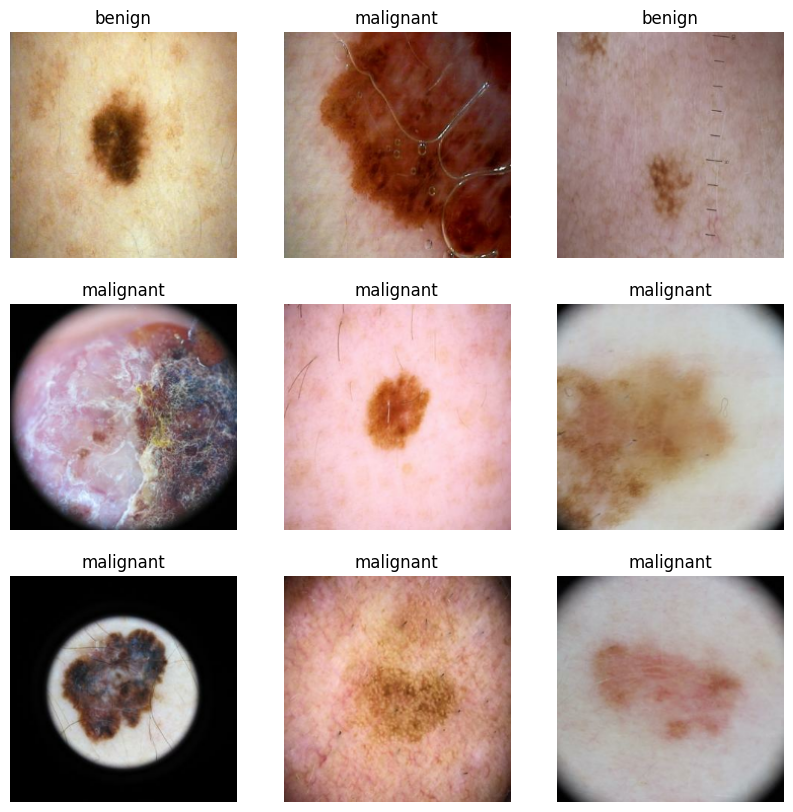

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for a in range(9):
        ax = plt.subplot(3, 3, a + 1)
        plt.imshow(images[a].numpy().astype("uint8"))
        plt.title(class_names[labels[a]])
        plt.axis("off")

In [22]:
# Check the shape of image and label batches
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [23]:
# Enable data prefetching for improved performance
AUTOTUNE = tf.data.AUTOTUNE

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
# Import VGG19 model and preprocess input
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

In [26]:
# Load the VGG19 model with pre-trained weights
vgg19 = VGG19(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False)
vgg19.input

80134624/80134624 [==============================] - 3s 0us/step


<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [27]:
# Freeze the layers of the VGG19 model
for layer in vgg19.layers:
    layer.trainable = False

In [28]:
# Define the number of classes
num_classes = 2

In [29]:
# Create a custom classification head on top of VGG19
x = layers.Flatten()(vgg19.output)
prediction = layers.Dense(num_classes, activation='softmax')(x)

In [30]:
# Create the final model
model = Model(inputs=vgg19.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
# Compile the model with loss and optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
# Set the number of training epochs
epochs = 10

In [33]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    steps_per_epoch=5,
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5/5 [==============================] - 43s 5s/step - loss: 5.2640 - accuracy: 0.6750 - val_loss: 4.9245 - val_accuracy: 0.7454
Epoch 2/10
5/5 [==============================] - 11s 3s/step - loss: 4.5729 - accuracy: 0.7812 - val_loss: 2.4620 - val_accuracy: 0.8532
Epoch 3/10
5/5 [==============================] - 11s 3s/step - loss: 5.0983 - accuracy: 0.7312 - val_loss: 2.0852 - val_accuracy: 0.8902
Epoch 4/10
5/5 [==============================] - 11s 3s/step - loss: 2.9387 - accuracy: 0.8813 - val_loss: 5.5731 - val_accuracy: 0.8199
Epoch 5/10
5/5 [==============================] - 11s 3s/step - loss: 5.2112 - accuracy: 0.8375 - val_loss: 2.8455 - val_accuracy: 0.8834
Epoch 6/10
5/5 [==============================] - 11s 3s/step - loss: 3.2550 - accuracy: 0.8625 - val_loss: 4.6081 - val_accuracy: 0.7751
Epoch 7/10
5/5 [==============================] - 11s 3s/step - loss: 2.1113 - accuracy: 0.8561 - val_loss: 2.6759 - val_accuracy: 0.8381
Epoch 8/10
5/5 [=============================

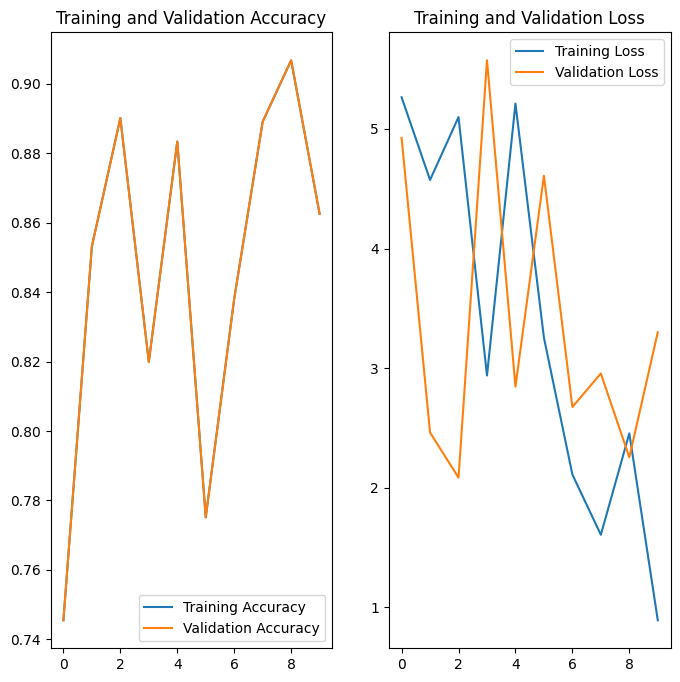

In [34]:
# Retrieve training history for plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy and loss
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, val_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()